In [1]:
# load the module
%load_ext autoreload
%autoreload 2

import Generating_Problems as Generator
import numpy as np
import matplotlib.pyplot as plt
import RQAOA
import networkx as nx
from copy import deepcopy 
from QIRO_MC import QIRO_MC
from classical_solver import find_maxcut
import classical_benchmarks.Simulated_Annealing as SA
import classical_benchmarks.Parallel_Tempering as PT
import classical_benchmarks.greedy_mis as GM
import random 
from typing import Tuple
import cvxpy as cvx 

### This is an old test where I have not performed graph renormalization 

### Complex graph

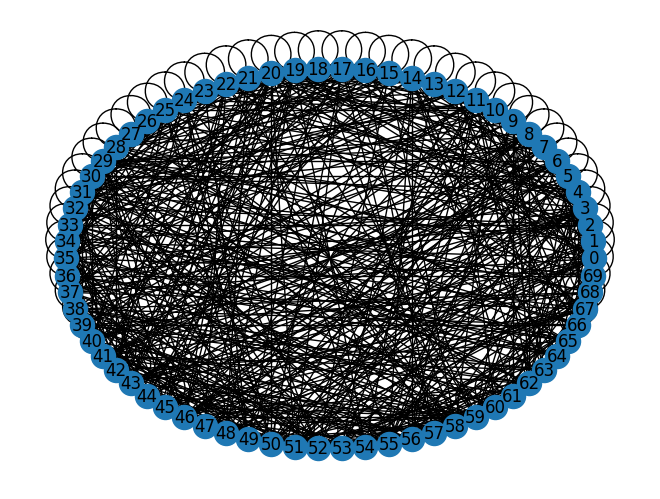

In [3]:
G = nx.random_geometric_graph(70,0.3)
for edge in G.edges(): 
    i = edge[0]
    j = edge[1]
    # G[i][j]['weight'] = random.randint(-9, 9)
    G[i][j]['weight'] = 1
G_without_loop = deepcopy(G)
for node in G.nodes(): 
    G.add_edge(node,node,weight = 0)
# Drawing the graph
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True)

# node_weights = nx.get_node_attributes(G, 'weight')
# nx.draw_networkx_labels(G, pos)

# edge_weights = nx.get_edge_attributes(G, 'weight')

# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)

plt.show()

In [4]:
problem = Generator.MaxCut(G)
qiro = QIRO_MC(problem, nc=4, strategy = "Max", no_correlation = 1,temperature = 8)
qiro.execute()
qiro_cost = problem.evaluate_solution(qiro.solution)
# print(f'QIRO solution: {qiro.solution}')
print(f'QIRO cost: {qiro_cost}')


C:\Users\PhamNguyenTa\AppData\Local\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


QIRO cost: 322


In [5]:
# max_cost, solutions = find_maxcut(G)
# print(f' Brute-force optimal solution: {max_cost}')
aprox_cost, aprox_solution = nx.algorithms.approximation.one_exchange(G, initial_cut=None, seed=None, weight= 'weight')
print(f'One_exchange cost (networkx): {aprox_cost}')
# We want to check if the cost is code correctly 
solution = []
for node in aprox_solution[0]: 
    solution.append(-(node+1))
for node in aprox_solution[1]: 
    solution.append((node+1))
sorted_solution = sorted(solution,key = lambda x: abs(x))
print(f'One_exchange_cost (our code) {problem.evaluate_solution(sorted_solution)}')
GW_tuple = goemans_williamson(G_without_loop)
GW_solution = GW_tuple[0]
GW_cost = GW_tuple[1]
print(f'GW cost (GW algorithm) {GW_cost}')

One_exchange cost (networkx): 317
One_exchange_cost (our code) 317


<class 'networkx.utils.decorators.argmap'> compilation 21:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


GW cost (GW algorithm) 315.0


### Comparison run

In [33]:
def experiment_setup(no_graph,min_node,max_node,step_node,no_sample,radius = 0.4,nc = 4, no_correlation = 1,temperature = 7):
    """
    This function is used to setup experiment and obtain the result 
    Input:
    - no_graph: The number of graph we want to test per setup 
    - min_node: The minimum number of nodes we want to test 
    - max_node: The maximum number of nodes we want to test 
    - step_node: The number of point we want to use in linspace(min_node,max_node,step_node)
    - no_sample: Number of run using QIRO per graph per setup 
    """
    
    node_array = np.linspace(min_node,max_node,step_node)
    efficiency_array_OE = np.zeros((step_node,no_graph,no_sample))
    efficiency_array_GM = np.zeros((step_node,no_graph,no_sample))
    for node_index in range(len(node_array)):
        
        no_node = int(node_array[node_index])
        for graph_index in range(no_graph): 
            
            # Setting up the graph
            print(f"Node {no_node},Graph {graph_index}")
            graph = nx.random_geometric_graph(no_node, radius)
            for edge in graph.edges(): 
                i = edge[0]
                j = edge[1]
                graph[i][j]['weight'] = 1
                # graph[i][j]['weight'] = random.randint(1, 9)
            graph_no_loop = deepcopy(graph)
            for node in graph.nodes(): 
                graph.add_edge(node,node,weight = 0)
                
            # Generate the problem 
            problem = Generator.MaxCut(graph)
            # QIRO cost           
            qiro = QIRO_MC(problem,nc,'Max',no_correlation,temperature)
            qiro.execute()
            qiro_cost = problem.evaluate_solution(qiro.solution)
            # Set up QIRO run 
            for sample_index in range(no_sample):
                # Obtain classical cost
                one_exchange_cost , _ = nx.algorithms.approximation.one_exchange(graph, initial_cut=None, seed=None, weight= 'weight')
                GW_tuple = goemans_williamson(graph_no_loop)
                GW_cost = GW_tuple[1]

                efficiency_array_OE[node_index,graph_index,sample_index] = one_exchange_cost/qiro_cost
                efficiency_array_GM[node_index,graph_index,sample_index] = GW_cost/qiro_cost
                    
    return efficiency_array_OE,efficiency_array_GM

In [17]:
efficiency_array_OE_1 ,efficiency_array_GM_1 = experiment_setup(30,40,40,1,10)

Node 40,Graph 0
Node 40,Graph 1
Node 40,Graph 2
Node 40,Graph 3
Node 40,Graph 4
Node 40,Graph 5
Node 40,Graph 6
Node 40,Graph 7
Node 40,Graph 8
Node 40,Graph 9
Node 40,Graph 10
Node 40,Graph 11
Node 40,Graph 12
Node 40,Graph 13
Node 40,Graph 14
Node 40,Graph 15
Node 40,Graph 16
Node 40,Graph 17
Node 40,Graph 18
Node 40,Graph 19
Node 40,Graph 20
Node 40,Graph 21
Node 40,Graph 22
Node 40,Graph 23
Node 40,Graph 24
Node 40,Graph 25
Node 40,Graph 26
Node 40,Graph 27
Node 40,Graph 28
Node 40,Graph 29


In [18]:
OE1_data = efficiency_array_OE_1[0,:,:]
GM1_data = efficiency_array_GM_1[0,:,:]
np.save('OE1_data',efficiency_array_OE_1)
np.save('GM1_data',efficiency_array_GM_1)

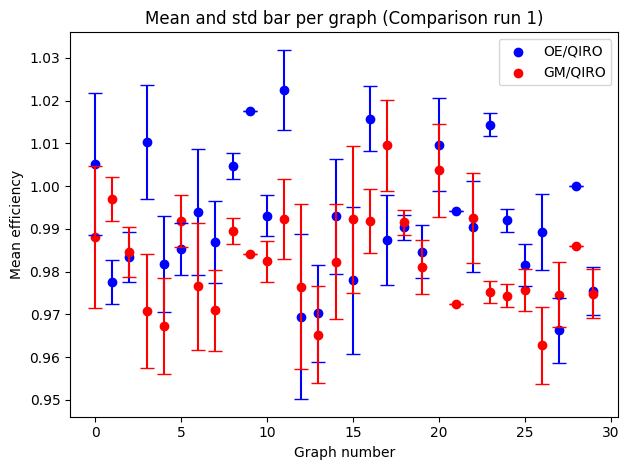

In [21]:
mean_OE1 = np.mean(OE1_data,axis=1)
std_OE1 = np.std(OE1_data,axis=1)

mean_GM1 = np.mean(GM1_data,axis=1)
std_GM1 = np.std(GM1_data,axis=1)

x_exp1 = np.arange(len(mean_GM1))
plt.scatter(x_exp1,mean_OE1,marker = 'o',color ='blue',label = 'OE/QIRO')
plt.errorbar(x_exp1,mean_OE1,yerr=std_OE1,fmt ='none',capsize=5,color='blue')

plt.scatter(x_exp1,mean_GM1,marker = 'o',color ='red',label = 'GM/QIRO')
plt.errorbar(x_exp1,mean_GM1,yerr=std_OE1,fmt ='none',capsize=5,color='red')

plt.xlabel("Graph number")
plt.ylabel("Mean efficiency")
plt.title("Mean and std bar per graph (equal weight, 40 nodes)")
plt.tight_layout()
plt.legend()
plt.show()

### Comparison run 2

In [22]:
efficiency_array_OE_2 ,efficiency_array_GM_2 = experiment_setup(30,60,60,1,10)


Node 60,Graph 0
Node 60,Graph 1
Node 60,Graph 2
Node 60,Graph 3
Node 60,Graph 4
Node 60,Graph 5
Node 60,Graph 6
Node 60,Graph 7
Node 60,Graph 8
Node 60,Graph 9
Node 60,Graph 10
Node 60,Graph 11
Node 60,Graph 12
Node 60,Graph 13
Node 60,Graph 14
Node 60,Graph 15
Node 60,Graph 16
Node 60,Graph 17
Node 60,Graph 18
Node 60,Graph 19
Node 60,Graph 20
Node 60,Graph 21
Node 60,Graph 22
Node 60,Graph 23
Node 60,Graph 24
Node 60,Graph 25
Node 60,Graph 26
Node 60,Graph 27
Node 60,Graph 28
Node 60,Graph 29


In [23]:
OE2_data = efficiency_array_OE_2[0,:,:]
GM2_data = efficiency_array_GM_2[0,:,:]
np.save('OE2_data',efficiency_array_OE_2)
np.save('GM2_data',efficiency_array_GM_2)

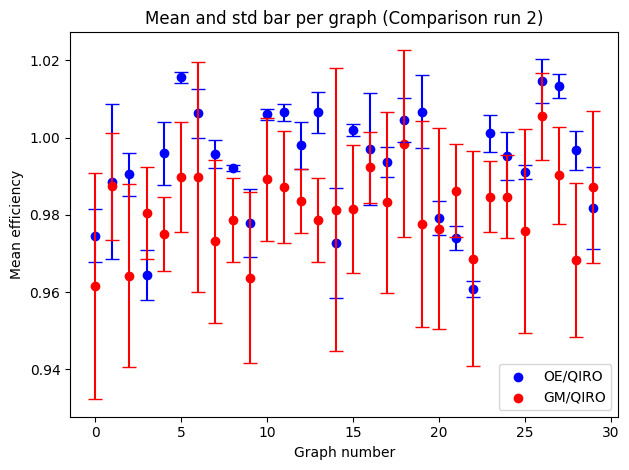

In [24]:
mean_OE2 = np.mean(OE2_data,axis=1)
std_OE2 = np.std(OE2_data,axis=1)

mean_GM2 = np.mean(GM2_data,axis=1)
std_GM2 = np.std(GM2_data,axis=1)

x_exp2 = np.arange(len(mean_GM2))
plt.scatter(x_exp2,mean_OE2,marker = 'o',color ='blue',label = 'OE/QIRO')
plt.errorbar(x_exp2,mean_OE2,yerr=std_OE2,fmt ='none',capsize=5,color='blue')

plt.scatter(x_exp2,mean_GM2,marker = 'o',color ='red',label = 'GM/QIRO')
plt.errorbar(x_exp2,mean_GM2,yerr=std_GM2,fmt ='none',capsize=5,color='red')

plt.xlabel("Graph number")
plt.ylabel("Mean efficiency")
plt.title("Mean and std bar per graph (Equal weight, 60 nodes)")
plt.tight_layout()
plt.legend()
plt.show()

In [26]:
efficiency_array_OE_3 ,efficiency_array_GM_3 = experiment_setup(30,40,40,1,10)

Node 40,Graph 0
Node 40,Graph 1
Node 40,Graph 2
Node 40,Graph 3
Node 40,Graph 4
Node 40,Graph 5
Node 40,Graph 6
Node 40,Graph 7
Node 40,Graph 8
Node 40,Graph 9
Node 40,Graph 10
Node 40,Graph 11
Node 40,Graph 12
Node 40,Graph 13
Node 40,Graph 14
Node 40,Graph 15
Node 40,Graph 16
Node 40,Graph 17
Node 40,Graph 18
Node 40,Graph 19
Node 40,Graph 20
Node 40,Graph 21
Node 40,Graph 22
Node 40,Graph 23
Node 40,Graph 24
Node 40,Graph 25
Node 40,Graph 26
Node 40,Graph 27
Node 40,Graph 28
Node 40,Graph 29


In [27]:
OE3_data = efficiency_array_OE_3[0,:,:]
GM3_data = efficiency_array_GM_3[0,:,:]
np.save('OE3_data',efficiency_array_OE_3)
np.save('GM3_data',efficiency_array_GM_3)

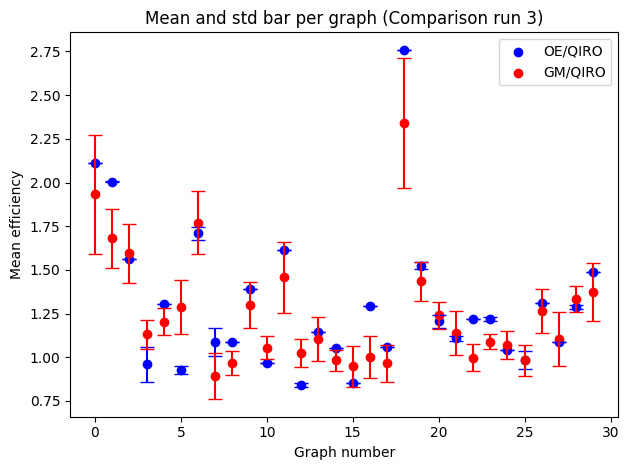

In [28]:
mean_OE3 = np.mean(OE3_data,axis=1)
std_OE3 = np.std(OE3_data,axis=1)

mean_GM3 = np.mean(GM3_data,axis=1)
std_GM3 = np.std(GM3_data,axis=1)

x_exp3 = np.arange(len(mean_GM3))
plt.scatter(x_exp3,mean_OE3,marker = 'o',color ='blue',label = 'OE/QIRO')
plt.errorbar(x_exp3,mean_OE3,yerr=std_OE3,fmt ='none',capsize=5,color='blue')

plt.scatter(x_exp3,mean_GM3,marker = 'o',color ='red',label = 'GM/QIRO')
plt.errorbar(x_exp3,mean_GM3,yerr=std_GM3,fmt ='none',capsize=5,color='red')

plt.xlabel("Graph number")
plt.ylabel("Mean efficiency")
plt.title("Mean and std bar per graph (40 nodes, random weight, both positive and negative)")
plt.tight_layout()
plt.legend()
plt.show()

In [30]:
efficiency_array_OE_4 ,efficiency_array_GM_4 = experiment_setup(30,40,40,1,10)

Node 40,Graph 0
Node 40,Graph 1
Node 40,Graph 2
Node 40,Graph 3
Node 40,Graph 4
Node 40,Graph 5
Node 40,Graph 6
Node 40,Graph 7
Node 40,Graph 8
Node 40,Graph 9
Node 40,Graph 10
Node 40,Graph 11
Node 40,Graph 12
Node 40,Graph 13
Node 40,Graph 14
Node 40,Graph 15
Node 40,Graph 16
Node 40,Graph 17
Node 40,Graph 18
Node 40,Graph 19
Node 40,Graph 20
Node 40,Graph 21
Node 40,Graph 22
Node 40,Graph 23
Node 40,Graph 24
Node 40,Graph 25
Node 40,Graph 26
Node 40,Graph 27
Node 40,Graph 28
Node 40,Graph 29


In [31]:
OE4_data = efficiency_array_OE_4[0,:,:]
GM4_data = efficiency_array_GM_4[0,:,:]
np.save('OE4_data',efficiency_array_OE_4)
np.save('GM4_data',efficiency_array_GM_4)

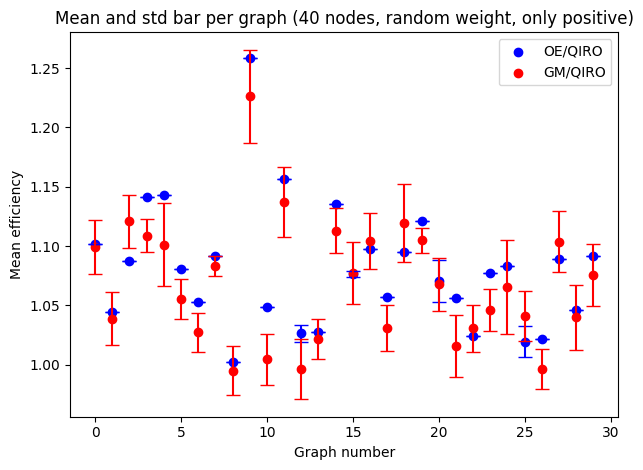

In [32]:
mean_OE4 = np.mean(OE4_data,axis=1)
std_OE4 = np.std(OE4_data,axis=1)

mean_GM4 = np.mean(GM4_data,axis=1)
std_GM4 = np.std(GM4_data,axis=1)

x_exp4 = np.arange(len(mean_GM4))
plt.scatter(x_exp4,mean_OE4,marker = 'o',color ='blue',label = 'OE/QIRO')
plt.errorbar(x_exp4,mean_OE4,yerr=std_OE4,fmt ='none',capsize=5,color='blue')

plt.scatter(x_exp4,mean_GM4,marker = 'o',color ='red',label = 'GM/QIRO')
plt.errorbar(x_exp4,mean_GM4,yerr=std_GM4,fmt ='none',capsize=5,color='red')

plt.xlabel("Graph number")
plt.ylabel("Mean efficiency")
plt.title("Mean and std bar per graph (40 nodes, random weight, only positive)")
plt.tight_layout()
plt.legend()
plt.show()

### Comparison run 5

In [39]:
efficiency_array_OE_5 ,efficiency_array_GM_5 = experiment_setup(20,20,80,7,10)

Node 20,Graph 0
Node 20,Graph 1
Node 20,Graph 2
Node 20,Graph 3
Node 20,Graph 4
Node 20,Graph 5
Node 20,Graph 6
Node 20,Graph 7
Node 20,Graph 8
Node 20,Graph 9
Node 20,Graph 10
Node 20,Graph 11
Node 20,Graph 12
Node 20,Graph 13
Node 20,Graph 14
Node 20,Graph 15
Node 20,Graph 16
Node 20,Graph 17
Node 20,Graph 18
Node 20,Graph 19
Node 30,Graph 0
Node 30,Graph 1
Node 30,Graph 2
Node 30,Graph 3
Node 30,Graph 4
Node 30,Graph 5
Node 30,Graph 6
Node 30,Graph 7
Node 30,Graph 8
Node 30,Graph 9
Node 30,Graph 10
Node 30,Graph 11
Node 30,Graph 12
Node 30,Graph 13
Node 30,Graph 14
Node 30,Graph 15
Node 30,Graph 16
Node 30,Graph 17
Node 30,Graph 18
Node 30,Graph 19
Node 40,Graph 0
Node 40,Graph 1
Node 40,Graph 2
Node 40,Graph 3
Node 40,Graph 4
Node 40,Graph 5
Node 40,Graph 6
Node 40,Graph 7
Node 40,Graph 8
Node 40,Graph 9
Node 40,Graph 10
Node 40,Graph 11
Node 40,Graph 12
Node 40,Graph 13
Node 40,Graph 14
Node 40,Graph 15
Node 40,Graph 16
Node 40,Graph 17
Node 40,Graph 18
Node 40,Graph 19
Node 50,Gr

In [40]:
np.save('OE5_data',efficiency_array_OE_5)
np.save('GM5_data',efficiency_array_GM_5)

In [41]:
OE5_data = efficiency_array_OE_5 
GM5_data = efficiency_array_GM_5

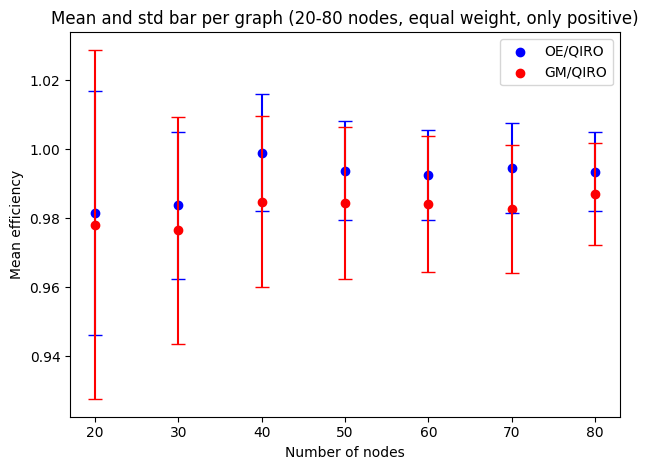

In [46]:
mean_OE5 = np.mean(OE5_data,axis=(1,2))
std_OE5 = np.std(OE5_data,axis=(1,2))

mean_GM5 = np.mean(GM5_data,axis=(1,2))
std_GM5 = np.std(GM5_data,axis=(1,2))

x_exp5 = np.linspace(20,80,7)
plt.scatter(x_exp5,mean_OE5,marker = 'o',color ='blue',label = 'OE/QIRO')
plt.errorbar(x_exp5,mean_OE5,yerr=std_OE5,fmt ='none',capsize=5,color='blue')

plt.scatter(x_exp5,mean_GM5,marker = 'o',color ='red',label = 'GM/QIRO')
plt.errorbar(x_exp5,mean_GM5,yerr=std_GM5,fmt ='none',capsize=5,color='red')

plt.xlabel("Number of nodes")
plt.ylabel("Mean efficiency")
plt.title("Mean and std bar per graph (20-80 nodes, equal weight, only positive)")
plt.tight_layout()
plt.legend()
plt.show()

### GW algorithm 

In [2]:
def goemans_williamson(graph: nx.Graph) -> Tuple[dict, float, float]:
    """
    The Goemans-Williamson algorithm for solving the maxcut problem.
    Ref:
        Goemans, M.X. and Williamson, D.P., 1995. Improved approximation
        algorithms for maximum cut and satisfiability problems using
        semidefinite programming. Journal of the ACM (JACM), 42(6), 1115-1145

    Returns:
        np.ndarray: Graph coloring (+/-1 for each node)
        float:      The GW score for this cut.
        float:      The GW bound from the SDP relaxation
    """

    laplacian = np.array(0.25 * nx.laplacian_matrix(graph).todense())

    # Setup and solve the GW semidefinite programming problem
    psd_mat = cvx.Variable(laplacian.shape, PSD=True)
    obj = cvx.Maximize(cvx.trace(laplacian @ psd_mat))
    constraints = [cvx.diag(psd_mat) == 1]
    prob = cvx.Problem(obj, constraints)
    prob.solve(solver=cvx.CVXOPT)

    # the sdp_vectors are the row vectors of the Cholesky decomposition matrix sdp_matrix = V * V.T
    sdp_vectors = np.linalg.cholesky(psd_mat.value)

    # Bound from the SDP relaxation
    bound = float(np.trace(laplacian @ psd_mat.value))

    
    random_vector = np.random.randn(sdp_vectors.shape[1])
    random_vector /= np.linalg.norm(random_vector)
    colors = np.sign([vec @ random_vector for vec in sdp_vectors])
    score = colors @ laplacian @ colors.T
    colors = 0.5 * (1 - colors)
    colors = {node: color for node, color in zip(list(graph.nodes()), colors)}

    return colors, score, bound